# Tackling the day o day 

Task´s description: Service tickets of technicians deployed to a store for an on-site repair. 

Did any of the events from the data sources above correlate with a service ticket? What type of information can be extracted from the service data? What data quality issues exist with this type of data and what are ways to overcome them?

In [1]:
# requirements 
from functools import reduce
from collections import Counter
#!pip install wordcloud
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import SnowballStemmer
#nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

path = 'C:/Users/user/Desktop/GitHub/Toshiba/'

### Did any of the events from the data sources above correlate with a service ticket?

No, none of the previously worked events correlate with the ticket data provided.

After examining the dates, it is easy to see why: the time periods are disjoint and the time seems to be the only way to relate these data sets, the events of the hosts are in the interval from January 6 to 7, 2021, while the ticket are recorded only on January 5, 2021.

In [2]:
events = pd.read_csv( path + 'Data/Events_guess.csv')
tickets = pd.read_csv(path + 'Data/serviceTicket1Day.csv')
print(tickets.head(2))
events['Linea'] = events['Date'] + ' ' + events['GMT Time']
events.Linea = pd.to_datetime(events.Linea, format='%m/%d/%Y %I:%M %p')
tickets['Creation Date'] = pd.to_datetime( tickets['Creation Date'])
tickets_filter = tickets.merge(events, how='inner', left_on='Creation Date', right_on='Linea')
tickets_filter

   Request Number   Creation Date  Task Number      Item  \
0         4921020  1/5/2021 22:18    6340476.0  0343-VC5   
1         4920346  1/5/2021 17:47    6340130.0  4900-745   

                         Item Description  Item Instance  Problem Code  \
0  Motorola VC5090 Portable Computer (DC)            NaN           NaN   
1                      SurePOS 700 Series            NaN           NaN   

   Resolution Code                                            Summary  \
0              NaN                               Missing Enter button   
1              NaN  TGCS FIELD - REG 61 - M#: 4900-745/S#: 41BA501...   

       Type  Status  Severity   Urgency Contact    Phone Customer Type  
0  Hardware  Closed  Standard  Standard              NaN  ORGANIZATION  
1  Hardware  Closed  Standard  Standard          2271289  ORGANIZATION  


,Request Number,Creation Date,Task Number,Item,Item Description,Item Instance,Problem Code,Resolution Code,Summary,Type,...,Message,S Code,E Code,Unique Data,Short Message,Message Explanation,UniqueDataDecoded,Value,Value_lag,Linea


### What type of information can be extracted from the service data? 

Although the data set of the tickets contains many null data, including null columns, it contains columns with very important information such as: `Item Description` and `Summary`.

If we assume that `Summary` contains information about the incident reported by the device (`Item Description`) in the `Request Number`, we can perform natural language processing with the information contained in this column to have information about which words are the most common in the ticket requests.


In [3]:
tickets_nlp = tickets[['Request Number', 'Summary']]
tickets_nlp.head(4)

,Request Number,Summary
0,4921020,Missing Enter button
1,4920346,TGCS FIELD - REG 61 - M#: 4900-745/S#: 41BA501...
2,4920416,TSI-REG 61 SCAN GUN WILL NOT SCAN OR CONFIGURE...
3,4919878,ABC- REG 1/ 4900-786/41AGNLK/Critical Power Su...


In [4]:
toktok = ToktokTokenizer()
stemmer = SnowballStemmer("english")
stops_en = stopwords.words('english')
def limpia ( indice):
    """ Funtion to token Summary column"""
    tokens_clean = [ stemmer.stem(x) for x in toktok.tokenize(  tickets_nlp.Summary[ indice ] ) if x.isalnum() and x not in stops_en ]
    #tokens_clean = [ x.lower() for x in toktok.tokenize(  tickets_nlp.Summary[ indice ] ) if x.isalnum() and x not in stops_en ]    
    return(tokens_clean)

In [5]:
corpus = list(map( lambda x: limpia(x), tickets_nlp.index ) ) 
texto = reduce(lambda x, y: x+y, corpus)
bolsa = Counter(texto)

                y
count  152.000000
mean     2.256579
std      3.190418
min      1.000000
25%      1.000000
50%      1.000000
75%      2.000000
max     26.000000


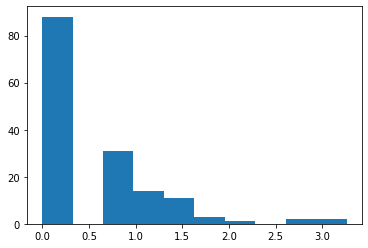

In [6]:
demo = pd.DataFrame(data=bolsa.values(), columns=['y'])
plt.hist( np.log( demo.y ) )
print(demo.describe()) 

We can see in the previous graph that the distribution of the occurrence of the words in the corpus is not much skewed, so we are working with a limited vocabulary __which is common in this type of context since it is a very specialized vocabulary__.


We can see, not surprisingly, that the word most frequently is precisely `TGCS`, the system name with which it works and therefore from which requests are reported.


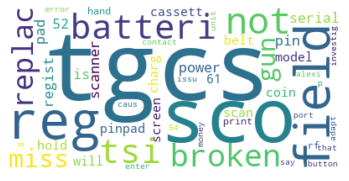

In [7]:
wc = WordCloud(background_color="white", max_words=50)
wc.generate_from_frequencies(bolsa)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Going further with NLP and graph theory

We can also take another approach. Let us consider each request record in the dataset and use the [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf#:~:text=In%20information%20retrieval%2C%20tf%E2%80%93idf,in%20a%20collection%20or%20corpus.&text=tf%E2%80%93idf%20is%20one%20of,popular%20term%2Dweighting%20schemes%20today) technique, in this way we can see each record, with its `Summary` column as the description of a problem or a document that summarizes an issue and using tf-idf we can associate a __measure of information to each record__ considering the information contained within the same column `Summary`. 

We proceed to do so.

In [8]:
temp = pd.DataFrame(bolsa.items(), columns=['Palabra', 'Freq'])
temp = temp.sort_values(by=['Freq'], ascending=False).reset_index()
temp['CumFreq'] = temp[['Freq']].cumsum()/ sum(temp.Freq)
temp.head(10)

,index,Palabra,Freq,CumFreq
0,3,tgcs,26,0.075802
1,47,sco,20,0.134111
2,5,reg,17,0.183673
3,4,field,15,0.227405
4,12,not,8,0.250729
5,87,tsi,7,0.271137
6,45,batteri,7,0.291545
7,62,broken,6,0.309038
8,22,replac,5,0.323615
9,0,miss,4,0.335277


In [9]:
tdf_corpus  = pd.DataFrame({'Request Number': tickets_nlp['Request Number']})
tdf_corpus['Problem'] = list(map (lambda x: ' '.join(x) , corpus) )
tdf_corpus
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(tdf_corpus['Problem'])
from scipy.sparse import csr_matrix
X = csr_matrix(X)
tdf_corpus['Measure']= pd.DataFrame(X.todense()).sum(axis=1)
tdf_corpus = tdf_corpus.sort_values('Measure', ascending=False)
tdf_corpus.head(10)

,Request Number,Problem,Measure
57,4916168,s sco 40 will not print error messag model ser...,3.109913
56,4914304,tgcs sco 52 belt come due dollar bill stuck track,3.074032
2,4920416,61 scan gun will not scan or configur model se...,3.014244
19,4919712,tgcs 61 will not reboot correct model serial 1...,2.930207
23,4914586,tgcs field cassett that hold money is have troubl,2.928552
41,4914668,tgcs field cassett that hold money is have troubl,2.928552
40,4914214,tsi reg 14 miss batteri cover hand scanner,2.789082
45,4914236,tsi reg 15 miss batteri cover hand scanner,2.789082
12,4919584,tgcs field sco 44 dl51101 sco say void tran,2.734779
38,4914154,tgcs sco 41 pin pad not read chip,2.721299


The last ten records appear to be the most informative in describing the problem, while the next ten are the least informative. 



In [10]:
tdf_corpus.tail(10)

,Request Number,Problem,Measure
28,4916774,screen broken drop,1.723991
17,4921032,charg contact broken,1.723991
29,4920946,reg scanner scan,1.693944
27,4919826,reg batteri replac batteri,1.580131
11,4919604,reg batteri replac batteri,1.580131
46,4915988,tsi,1.000000
48,4915622,stay,1.000000
30,4915742,stay,1.000000
24,4920898,,0.000000
9,4920462,,0.000000


Now that we have a representation of the `problems`, measured through the `Summary` column, which are essentially only 54 different and that we now have a measure of information related to them, we can look at the information contained in the `Item Description` column, which we _suppose to describe the device associated with the request on which the failure is reported_.
On the `Item Description` column in the dataset there are only 24 different values. So, in principle __we can model this problem as a graph problem__, a directed bipartite graph, where the set of nodes $P$ (in red in the following figure) contains 54 nodes of problems that we found using NLP, the set of nodes $I$ contains 24 nodes (in blue color) that represent each of the devices that was reported failures. The set of directed edges $E = (i, p), i \in \& p \in P$, indicates that the device $i$ reports the problem $p$ and since we now have a _measure_, we can associate it to the weight of this edge.

In the previous way we have built a directed graph that represents the information, not only between the requests, which is easily extensible, but also between the items and the problems and the importance that these must __find the root cause of them__.

There are ways to __improve the modeling__, with the current graph we can use a vertex ranking algorithm such as PageRank and rank the nodes to determine which Item and which problem have been the most important, this corresponds to a post-mortem analysis and well if we want to __go one step further__ and take the analysis to another level, we could include extra information such as:

   * Information between problem-problems. That is, if a problem was solved, how it was solved and what relationship or edges it adds to the $P$ nodes.
   * Relations on items and items. The devices are well known so they must share characteristics that are known from the factory, coupled with the fact of laboratory studies and insights from the data team itself, so this information can be added as edges between nodes $I$.
   * Include the request time, although this implies an important trade off since it increases the computational complexity quite a bit from the outset, the graph algorithms are highly complex since they depend on both the number of nodes and edges, including the time in them would add the least another order of complexity and the cost benefit should be evaluated in addition to the time of implementation and maintenance of the model.


The three previous points together or only one of them would add enough information to go from a DAG to a structure that would provide the basis for applying popular `Social network analysis` techniques and finding the _inverse problem_: __we are observing the flaws or consequences (failures, incidents, etc.) ok, so what is the problem?__

And even more so in my [experience](https://github.com/fou-foo/RMF2Coppel/blob/master/LegacyCode/CodeAntonio%20(gcp)/IBMESprint3/Collaborative_Filtering_NN_model%20_antonio_gcp_02porciento.ipynb), this structure provides enough information to make a [recommendation system], which in this context it is to recommend the best solution for a given request, Item and Summary.




In [11]:
temp = [ i for i in tdf_corpus.Problem if i != '']
temp = set(temp)
print(len(temp) )
graph_df = tdf_corpus.merge(tickets[['Request Number', 'Item Description']])
print(len(graph_df['Item Description'].unique()) )
graph_df.head(3)

54
24


,Request Number,Problem,Measure,Item Description
0,4916168,s sco 40 will not print error messag model ser...,3.109913,TGC Self Checkout System 6 Scanning + Payment ...
1,4914304,tgcs sco 52 belt come due dollar bill stuck track,3.074032,POS SELF CHECK OUT
2,4920416,61 scan gun will not scan or configur model se...,3.014244,Motorola DS6878-SR20007WR


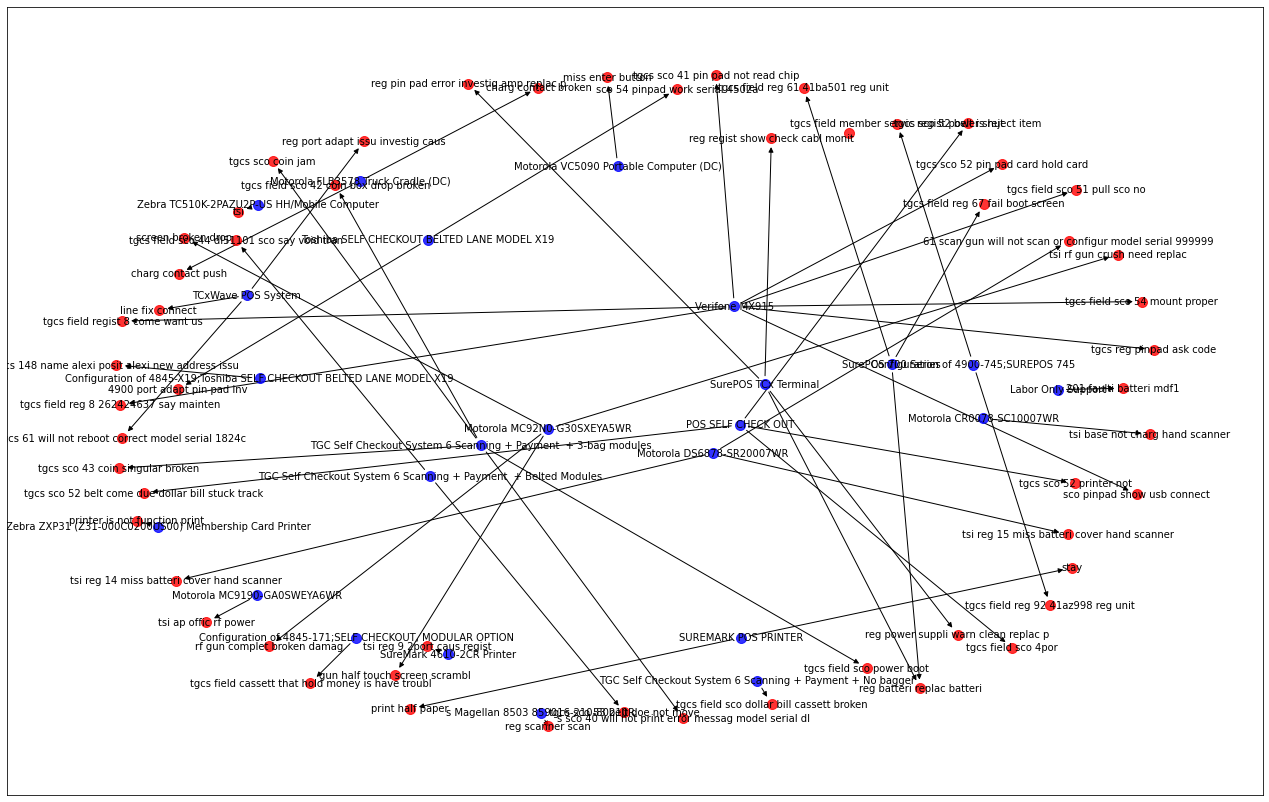

In [12]:
import networkx as nx
graph = nx.DiGraph()
options = {"node_size": 100, "alpha": 0.8}
for i in graph_df['Item Description'].unique():
    graph.add_node(str(i))
for i in graph_df['Problem'].unique():
    graph.add_node(str(i))

for i in graph_df.index:
    if graph_df.Measure[i] > 0:
        graph.add_edge(graph_df['Item Description'][i], graph_df['Problem'][i], weight=1)#, width=6)#, weight=graph_df.Measure[i])

l = {} 
coco = 0
for i in graph.nodes():
    l[i] = i
    coco = coco +1 
pos = nx.spring_layout(graph)
nx.draw_networkx_nodes(graph, pos, nodelist=graph_df['Item Description'].unique(), node_color="b", **options)
nx.draw_networkx_nodes(graph, pos, nodelist=graph_df['Problem'].unique(), node_color="r", **options)
nx.draw_networkx_edges(graph, pos, edgelist=[(u, v) for (u, v, d) in graph.edges(data=True) ], 
                       edge_color='k', style='solid',  arrowsize =10,)
nx.draw_networkx_labels(graph, pos, labels=l , font_size=10, font_color="k")
fig = plt.gcf()
fig.set_size_inches(22.5, 14.5)
plt.show(graph )

### What data quality issues exist with this type of data and what are ways to overcome them?

At this point we can remember what Til Schuermann writes in his work [What Do We Know About Loss Given Default?](http://mx.nthu.edu.tw/~jtyang/Teaching/Risk_management/Papers/Recoveries/What%20Do%20We%20Know%20About%20Loss-Given-Default.pdf):

> but as usual the devil is in the details

And as I usually say

> but as usual the devil is in the details, especially working with data

Nulls are always an issue in all data work. In these exercises we do not need to impute data, which is a widely studied process that must be done with care, since __imputing data__ in an inappropriate way reduces the sample variance and therefore would induces numerous problems; however, we find numerous columns where most of their content is empty.
This is relevant from three points of view: statistical, computational, and engineering.

From a statistical point of view, having more variables does not always guarantee more information and that has been known since the times of the central limit theorem and currently with the rise of big data we are increasingly facing the problem of the curse of dimensionality and high dimensional data and sometimes small sample size; so, when I saw in this test so many empty columns, I don't consider them analysis at first. However, if the need arises to impute an important numerical column, as a first approximation, I would consider the traditional statistical techniques, which I doubt were very effective, then I would try with non-parametric methods and __I consider that this is a good use case for the application of the [FDA](https://en.wikipedia.org/wiki/Functional_data_analysis)__ since sensors have a hardware component that is governed by physics and therefore its interaction with external factors can be modeled by a dynamic system, and by Software means this control can be included with __FDA methods__.

Between statistics and computer science in the three exercises time device measurements was reported, with the characteristic that these are __not equally spaced__. So __traditional time series modeling techniques have to be adjusted__ to be used or adjust the data to be used, yes data augmentation!, for example establishing milliseconds as the unit of measure and if the time $t$ exists in the data series of a sensor with the value $x_t$ but $t + 1ms$ is not reported so we add $t + 1ms$ and repeat the value $x_t$, however this strategy introduces bias and also increases the processing time of any algorithm that be tested. For this reason, I choose not to use the previous techniques and to use the raw data. Working with dates always involves important details like date type, EPOCH, UNIX, time zone, etc.

Data used for NLP tasks and graphs. The text preprocessing carried out has areas of opportunity such as: __word selection, correction of typos and orthography and can be improved with the recognition of entities__, among others.

The selection of words to be included, to be clearer defining what is a stop word and what is not, could greatly improve the performance of this type of models and this is achieved through the construction of own corpus or vocabulary, which follows being an open problem in the academy for each language and its variants, however in the private initiative I am aware that banking and retail have already been working on it for some time ago.

The correction of typos and spelling can be done by means of the own corpus or, failing that, by tools such as [Aspell](http://aspell.net/).

As for the detection of entities for text, it is a more complex task that involves both graph theory and NLP and NLU, which although they require more computing resources in addition to providing more metacontext to the data, helps to detect quality problems in them.
